In [6]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [7]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [8]:
DIRECTORY = r"D:\Agrotrace\Potato disease detector opencv\Potato-image-detector\Potato"
CATEGORIES = ["Potato_Early_blight","Potato_Late_blight"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

[INFO] loading images...


In [9]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

In [10]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


In [11]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [12]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

9412608/9406464 [==============================] - 4s 0us/step


In [13]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [14]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] compiling model...
[INFO] training head...
Epoch 1/20
50/50 [==============================] - 26s 514ms/step - loss: 0.6260 - accuracy: 0.6956 - val_loss: 0.2576 - val_accuracy: 0.9250
Epoch 2/20
50/50 [==============================] - 25s 503ms/step - loss: 0.2629 - accuracy: 0.8975 - val_loss: 0.1640 - val_accuracy: 0.9550
Epoch 3/20
50/50 [==============================] - 25s 501ms/step - loss: 0.1853 - accuracy: 0.9300 - val_loss: 0.1157 - val_accuracy: 0.9800
Epoch 4/20
50/50 [==============================] - 25s 497ms/step - loss: 0.1496 - accuracy: 0.9438 - val_loss: 0.1027 - val_accuracy: 0.9775
Epoch 5/20
50/50 [==============================] - 25s 502ms/step - loss: 0.1314 - accuracy: 0.9469 - val_loss: 0.0875 - val_accuracy: 0.9775
Epoch 6/20
50/50 [==============================] - 25s 502ms/step - loss: 0.1009 - accuracy: 0.9663 - val_loss: 0.0763 - val_accuracy: 0.9775
Epoch 7/20
50/50 [==============================] - 25s 504ms/step - loss: 0.0907 - accuracy

[INFO] evaluating network...
                     precision    recall  f1-score   support

Potato_Early_blight       0.99      0.97      0.98       200
 Potato_Late_blight       0.98      0.99      0.99       200

           accuracy                           0.98       400
          macro avg       0.99      0.98      0.98       400
       weighted avg       0.99      0.98      0.98       400

[INFO] saving mask detector model...


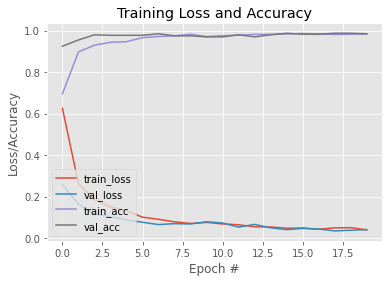

In [15]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("D:\Agrotrace\Potato disease detector opencv\Potato-image-detector\disease_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")